# Human MRI example

In this example we register a pair of 3D human brain MR images.

First we walk through the example in this notebook.

Then we write config files to disk, and run the example from the command line.  The command line interface has only been validated on Linux systems.

## Import libraries

In [1]:
# numpy for multidimensional arrays to store images
import numpy as np
# matplotlib for visualization
import matplotlib.pyplot as plt 
# the command below will allow interactive figures that update as code runs
%matplotlib notebook

# import tools for working with files
from os import makedirs
from os.path import join

# import the json library for writing out config files
import json

# import the subprocess library for running code from command line
import subprocess

# import the emlddmm image registration library
import sys
sys.path.append('../..')
import emlddmm

## Outputs


In [2]:
output_directory = 'human_mri_example_notebook_outputs'

In [3]:
makedirs(output_directory,exist_ok=True)

## Load images

In [4]:
target_name = 'TargetMRI.vtk'
atlas_name = 'AtlasMRI.vtk'
label_name = 'AtlasLabels.vtk'

<IPython.core.display.Javascript object>


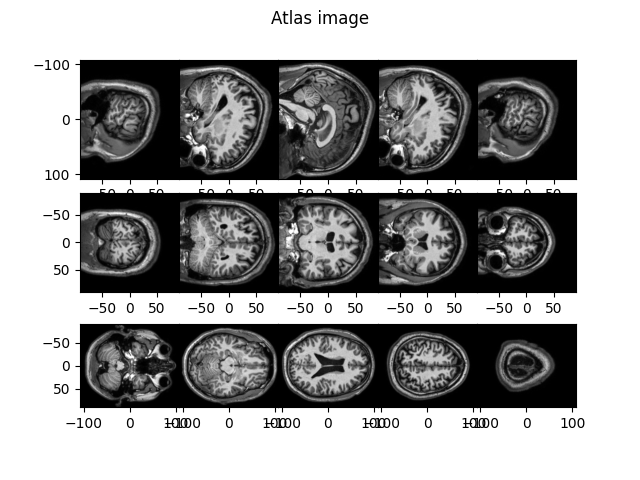

Text(0.5, 0.98, 'Atlas image')

In [5]:
# load the atlas with normalization (mean of abs is 1)
xI,I,_,_ = emlddmm.read_data(atlas_name,normalize=True)
# draw a picture
fig,ax = emlddmm.draw(I,xI,cmap='gray')
fig.suptitle('Atlas image')

<IPython.core.display.Javascript object>


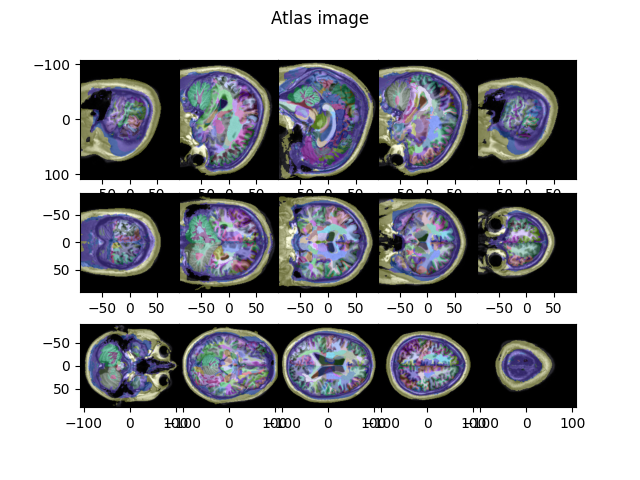

Text(0.5, 0.98, 'Atlas image')

In [6]:
# load the atlas segmentation labels, with no normalization (because these are integer labels)
xS,S,_,_ = emlddmm.read_data(label_name)
SRGB = emlddmm.labels_to_rgb(S,black_label=256)
# draw a picture, showing labels and MRI
fig,ax = emlddmm.draw(SRGB+I/np.max(I)*2.0,xS)
fig.suptitle('Atlas image')

<IPython.core.display.Javascript object>


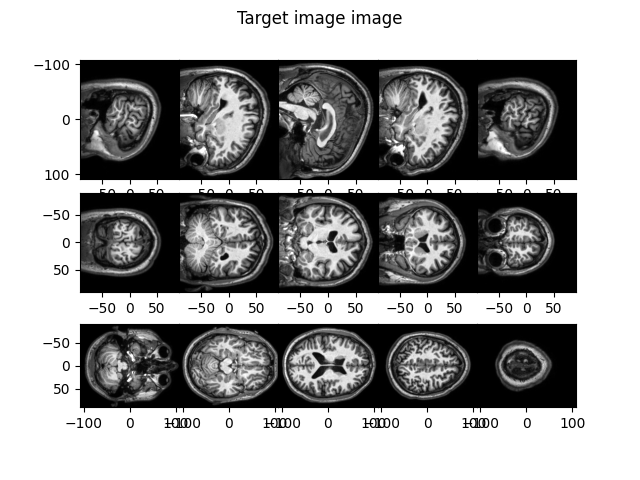

Text(0.5, 0.98, 'Target image image')

In [7]:
# load the target with normalization (mean of abs is 1)
xJ,J,_,_ = emlddmm.read_data(target_name,normalize=True)
# draw a picture
fig,ax = emlddmm.draw(J,xJ,cmap='gray')
fig.suptitle('Target image image')

In [8]:
# run registration at 3 different spatial scales

In [9]:
config = {
    'device':'cpu', # cpu or cuda:0
    'downI':[[4,4,4],[2,2,2],[1,1,1]], # downsampling factors for atlas at multiple scales
    'downJ':[[4,4,4],[2,2,2],[1,1,1]], # downsampling factors for target at multiple scales
    'n_iter':[50,40,30], # how many iterations of gradient descent at each scale
    'v_start':[0], # at what iteration of gradient descent do we start optimizing over deformation
    'eA': [1e1], # gradient descent stepsize for 3D affine transform    
    'ev':[5e-1], # gradient descent stepsize for the deformation
    'a':2.0, # spatial scale of deformation
    'dv':2.0, # sampling interval for deformation
    'sigmaR':5e0, # regularizatoin for deformation (bigger means less regularization)    
    'local_contrast':[[32,32,32]] # divide the images into small blocks to estimate contrast differences
}

Found 3 scales


<IPython.core.display.Javascript object>


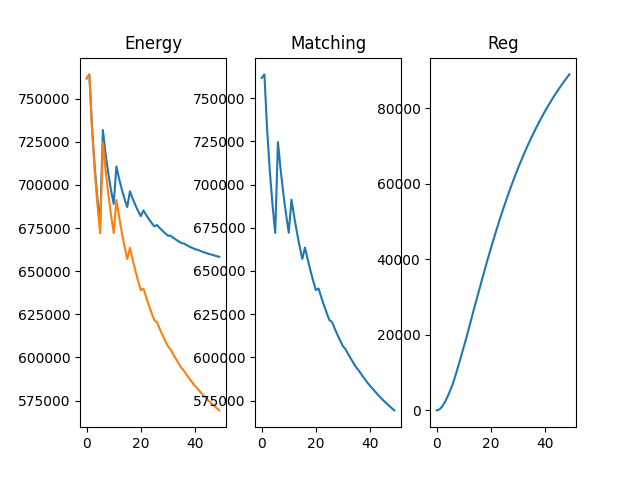

<IPython.core.display.Javascript object>


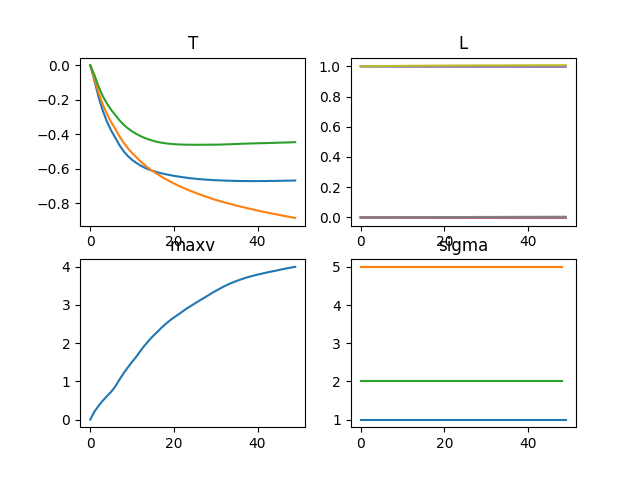

<IPython.core.display.Javascript object>


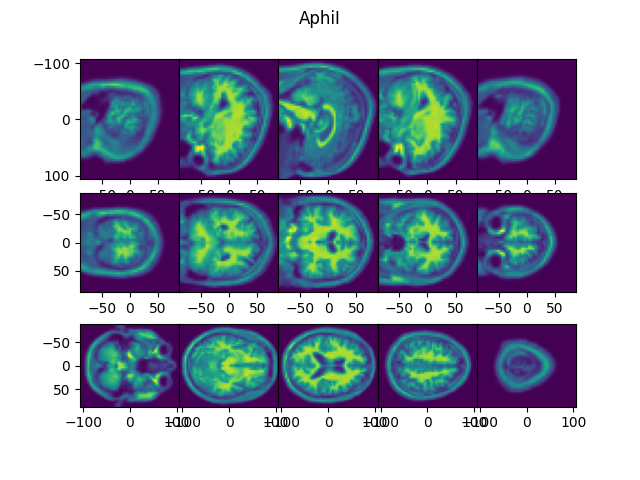

<IPython.core.display.Javascript object>


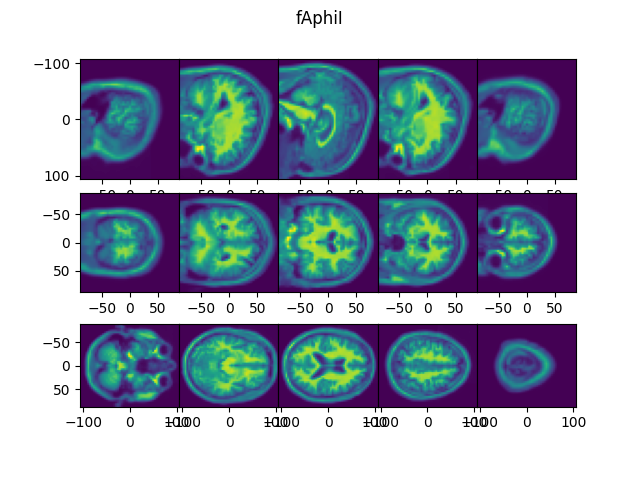

<IPython.core.display.Javascript object>


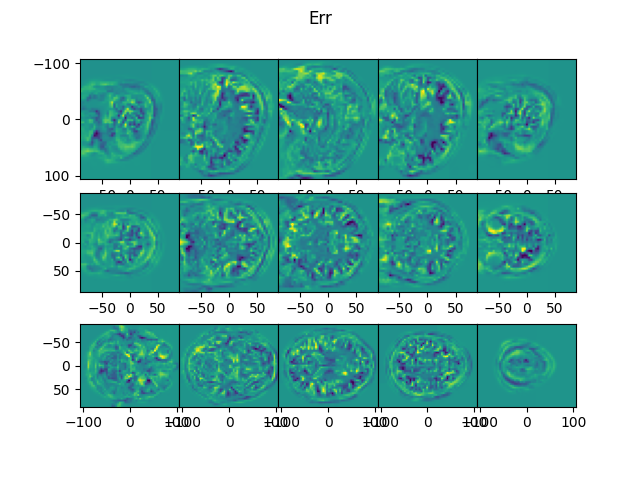

<IPython.core.display.Javascript object>


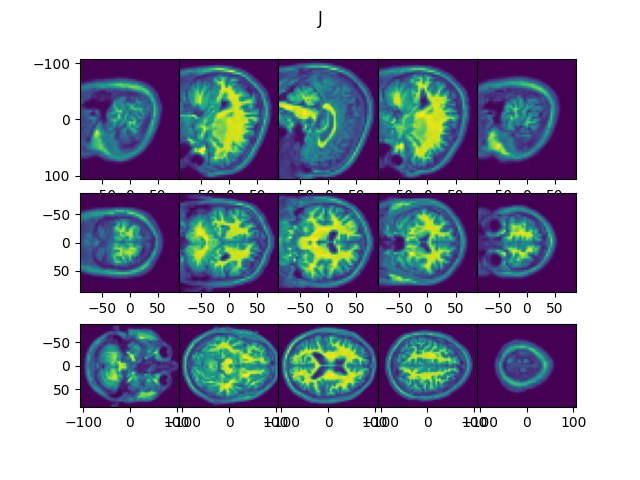

<IPython.core.display.Javascript object>


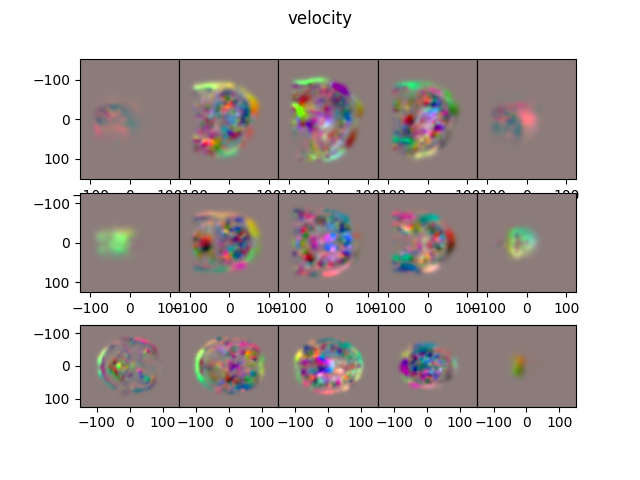

<IPython.core.display.Javascript object>


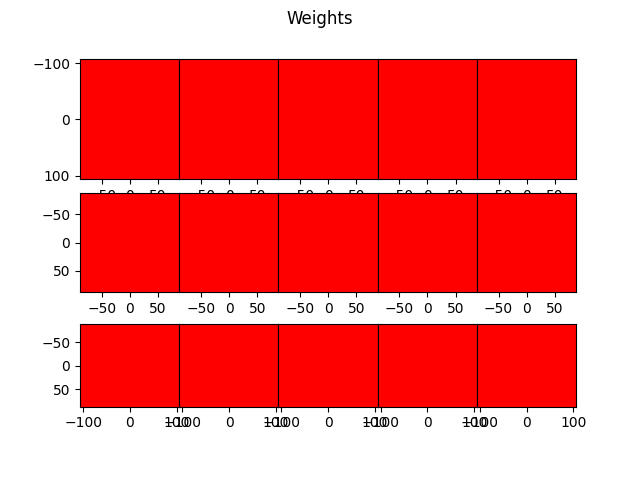

../../emlddmm.py:175: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Iteration 30, linear oscilating, reducing eA to 9.0
Iteration 40, translation oscilating, reducing eA to 8.1


../../emlddmm.py:1334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v.detach().clone(),device=device,dtype=dtype)
../../emlddmm.py:1378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A.detach().clone(),device=device,dtype=dtype)


<IPython.core.display.Javascript object>


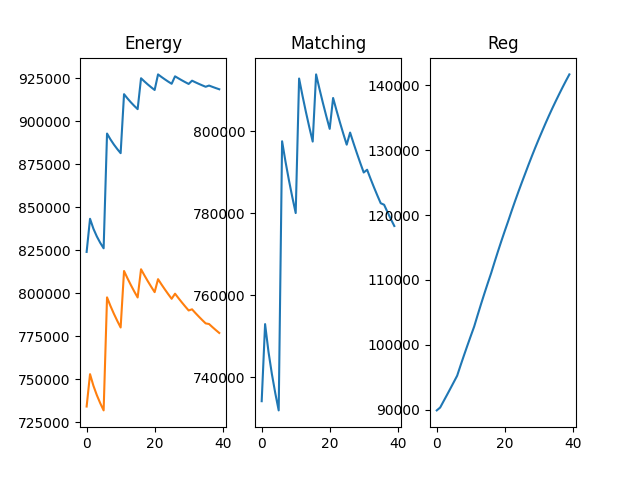

<IPython.core.display.Javascript object>


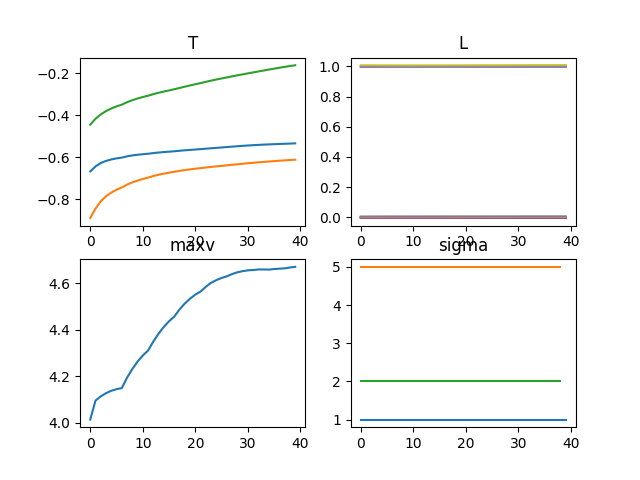

<IPython.core.display.Javascript object>


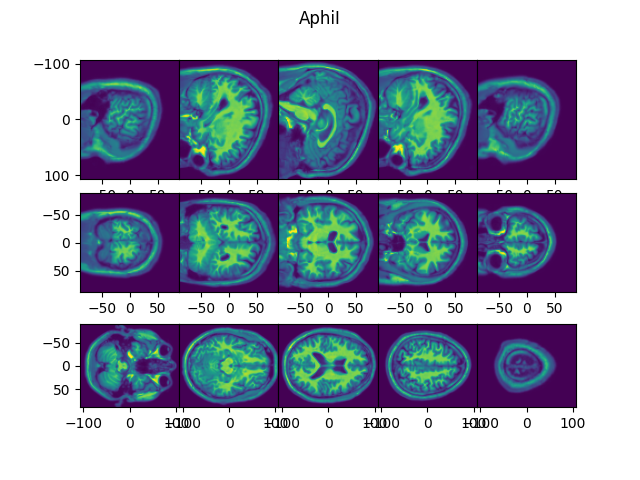

<IPython.core.display.Javascript object>


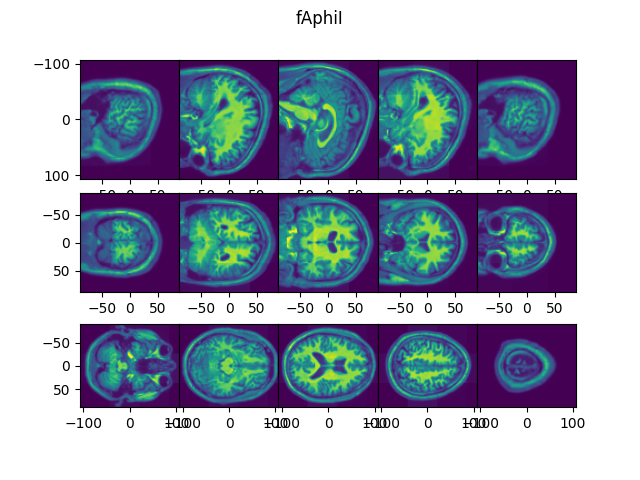

<IPython.core.display.Javascript object>


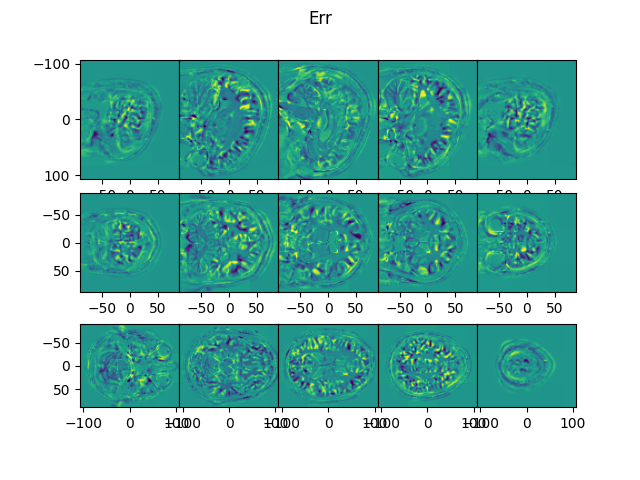

<IPython.core.display.Javascript object>


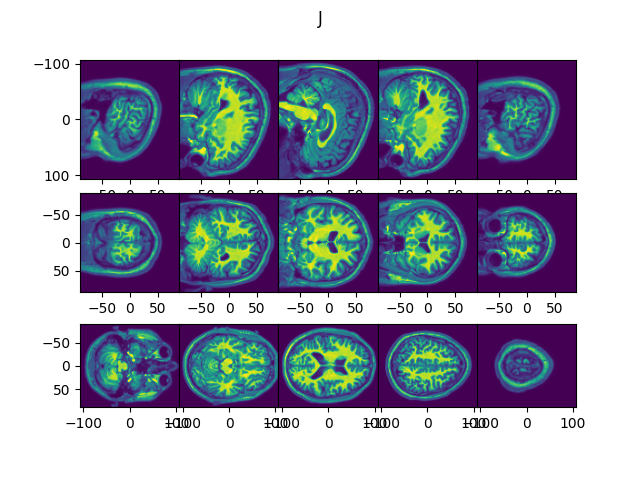

<IPython.core.display.Javascript object>


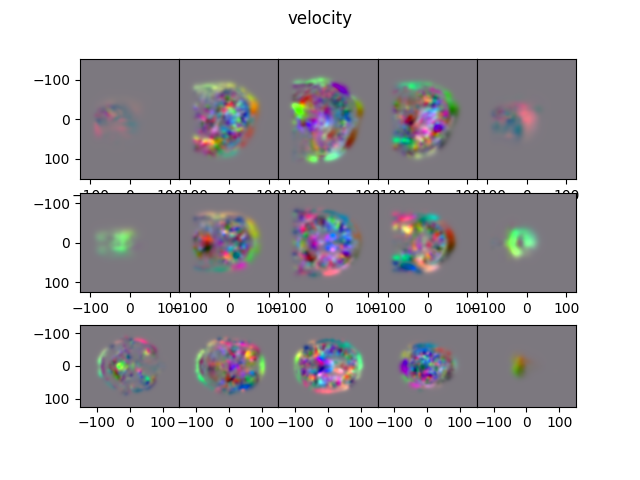

<IPython.core.display.Javascript object>


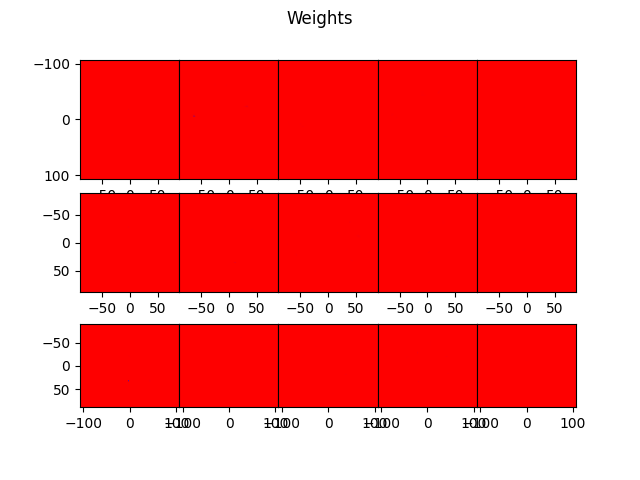

<IPython.core.display.Javascript object>


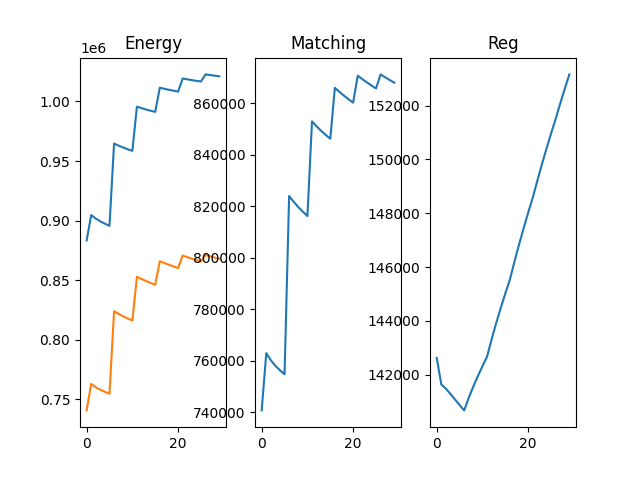

../../emlddmm.py:1445: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figA,axA = plt.subplots(2,2)


<IPython.core.display.Javascript object>


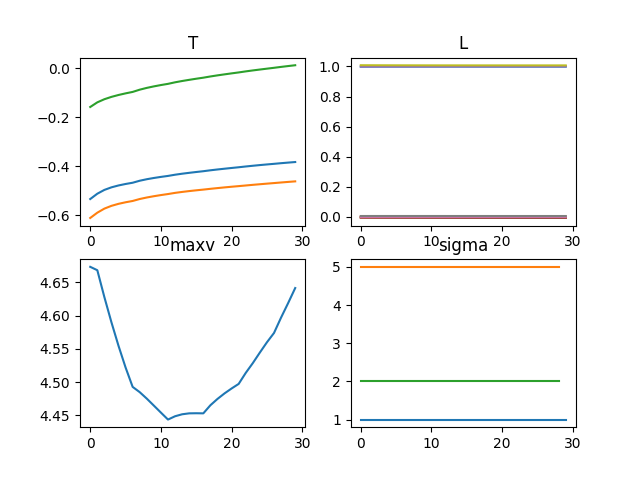

<IPython.core.display.Javascript object>


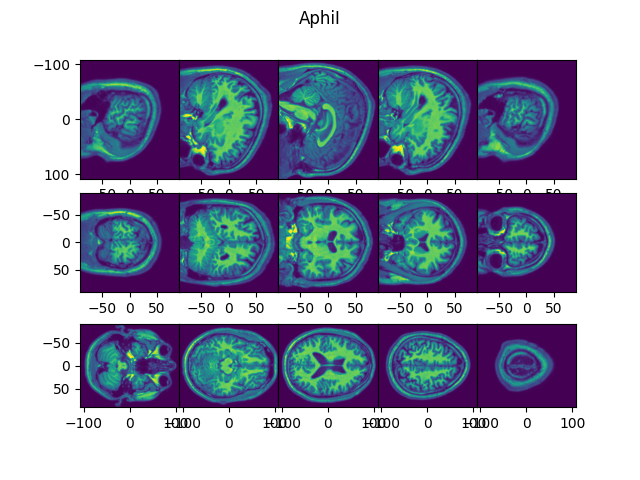

<IPython.core.display.Javascript object>


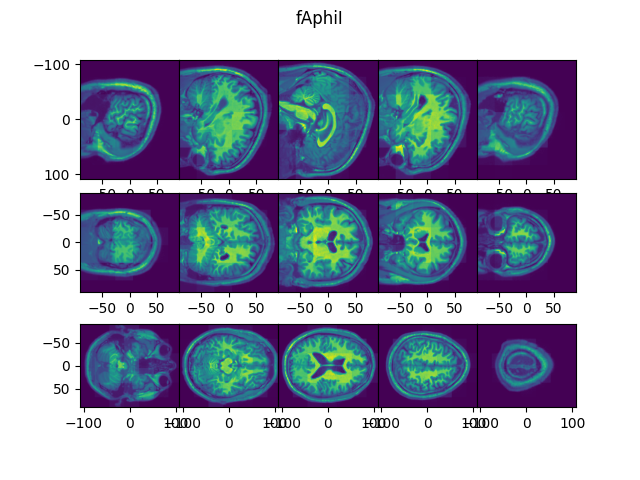

<IPython.core.display.Javascript object>


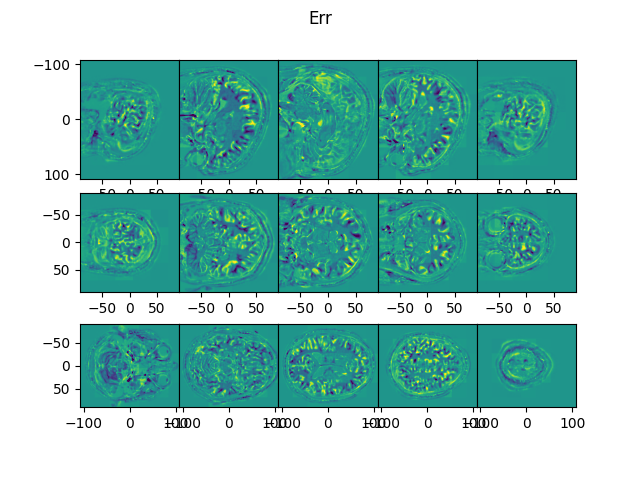

<IPython.core.display.Javascript object>


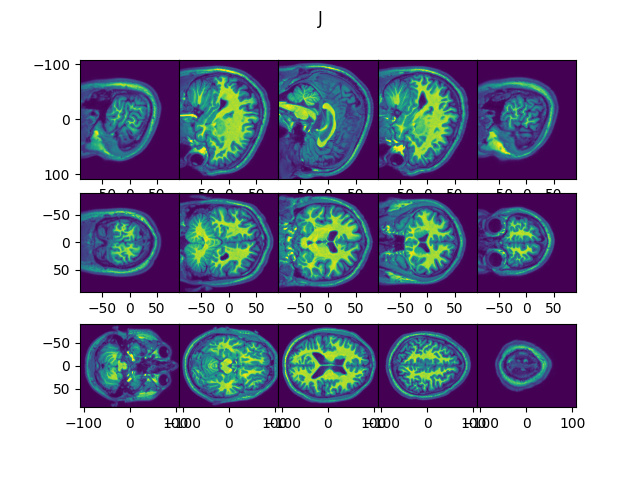

<IPython.core.display.Javascript object>


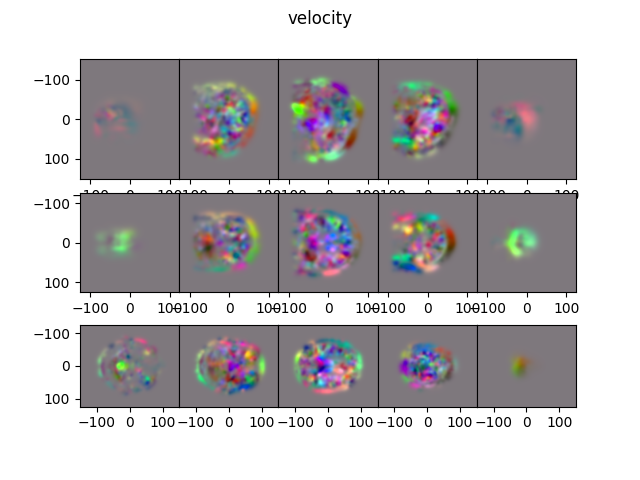

<IPython.core.display.Javascript object>


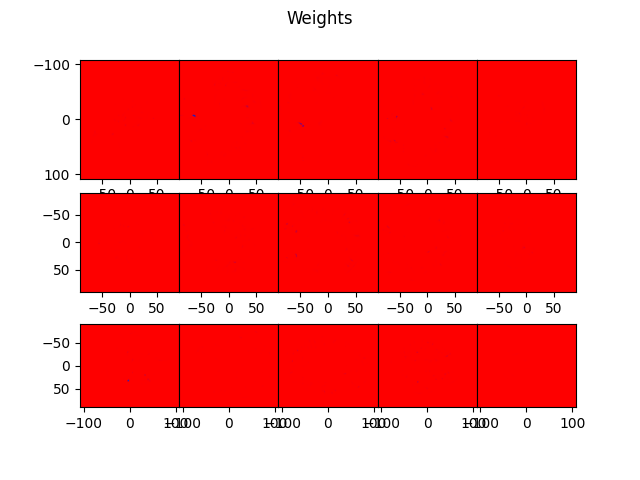

In [10]:
out = emlddmm.emlddmm_multiscale(xI=[xI],I=I,xJ=[xJ],J=J,**config)

## apply the transform to the atlas image
We use the backward (inverse) transformations.

In [11]:
tform = emlddmm.compose_sequence(
    [
        emlddmm.Transform(out[-1]['A'],direction='b'),
        emlddmm.Transform(out[-1]['v'],domain=out[-1]['xv'],direction='b')
    ],
    xJ
)
AphiI = emlddmm.apply_transform_float(xI,I,tform)
AphiS = emlddmm.apply_transform_int(xS,S,tform)

<IPython.core.display.Javascript object>


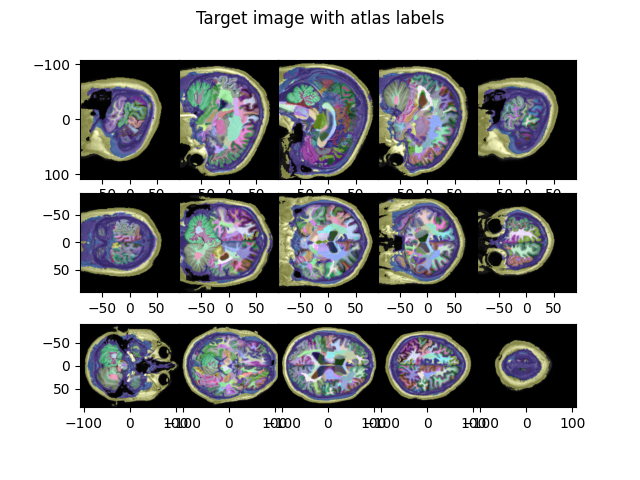

Text(0.5, 0.98, 'Target image with atlas labels')

In [12]:
# draw the labels over the target image
AphiSRGB = emlddmm.labels_to_rgb(AphiS,black_label=256)
# draw a picture, showing labels and MRI
fig,ax = emlddmm.draw(AphiSRGB+J/np.max(J)*2.0,xJ)
fig.suptitle('Target image with atlas labels')

In [13]:
# save the transformed images
emlddmm.write_data(join(output_directory,'atlas_labels_to_target.vtk'),xJ,AphiS,title='atlas_labels_to_target')
emlddmm.write_data(join(output_directory,'atlas_image_to_target.vtk'),xJ,AphiI,title='atlas_image_to_target')

## apply the transform to the target image
We use the forward transformation

In [14]:
# transform target back to template
tform = emlddmm.compose_sequence(
    [        
        emlddmm.Transform(out[-1]['v'],domain=out[-1]['xv'],direction='f'),
        emlddmm.Transform(out[-1]['A'],direction='f'),
    ],
    xI
)
phiiAiJ = emlddmm.apply_transform_float(xJ,J,tform)

# resample target on template voxels
tform = emlddmm.compose_sequence([emlddmm.Transform(np.eye(4))],xI)
Jresampled = emlddmm.apply_transform_float(xJ,J,tform)

<IPython.core.display.Javascript object>


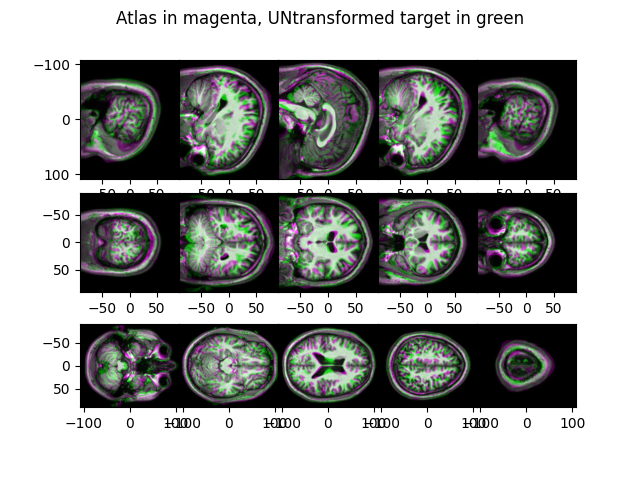

<IPython.core.display.Javascript object>


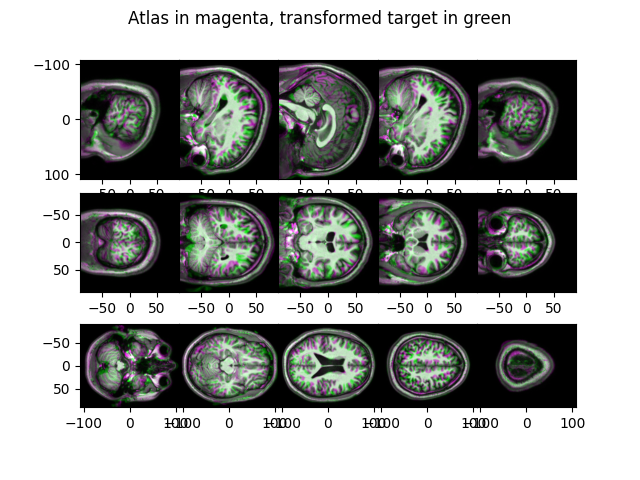

Text(0.5, 0.98, 'Atlas in magenta, transformed target in green')

In [15]:
fig,ax = emlddmm.draw(np.concatenate((I,Jresampled)),xI)
fig.suptitle('Atlas in magenta, UNtransformed target in green')

fig,ax = emlddmm.draw(np.concatenate((I,phiiAiJ)),xI)
fig.suptitle('Atlas in magenta, transformed target in green')

In [16]:
# save the transformed image
emlddmm.write_data(join(output_directory,'target_image_to_atlas.vtk'),xJ,AphiS,title='target_image_to_atlas')

## Run the same analysis using the command line interface

Next we will show how to produce necessary config files, and run the same example using our transformation graph command line interface.

## write out a config file for registration

In [17]:
config_file = 'atlas_to_target_config.json'
with open(config_file,'wt') as f:
    json.dump(config,f)

## write out a config file for the transformation graph

In [18]:
transformation_config = {
  "output": "output",
  "space_image_path": [
    [
      "Atlas",
      "image",
      atlas_name
    ],
    [
      "Atlas",
      "labels",
      label_name
    ],
    [
      "Target",
      "image",
      target_name
    ],        
  ],
  "registrations": [
    [
      [
        "Atlas",
        "image"
      ],
      [
        "Target",
        "image"
      ]
    ],        
  ],      
  "configs": [
    config_file,   
      
  ],
  "transform_all":True,
}
transformation_config_file = 'transformation_graph_config.json'
with open(transformation_config_file,'wt') as f:
    json.dump(transformation_config,f)

## Run this example from the command line

We will write out the parameters above to a config file, and run our command line interface.  This will produce all our standard outputs.

In [19]:
command = f'python -u ../../transformation_graph_v01.py --infile {transformation_config_file} > outputs.txt 2>&1'
print('about to run command:')
print(command)

about to run command:
python -u ../../transformation_graph_v01.py --infile transformation_graph_config.json > outputs.txt 2>&1


In [20]:
subprocess.call(command,shell=True)

0

## View all the outputs

All the output directories are printed below.  Note that this includes a python file graph.p, which contains information about the transformation graph. This will allow us to apply the transforms we have already calculated to new datasets later.

In [27]:
from os import walk
for dirpath,dirnames,filenames in walk('output',):
    for f in filenames:
        print(join(dirpath,f))

output/infile.json
output/graph.p
output/Atlas/Target_to_Atlas/transforms/velocity.vtk
output/Atlas/Target_to_Atlas/transforms/A.txt
output/Atlas/Target_to_Atlas/transforms/Target_to_Atlas_displacement.vtk
output/Atlas/Target_to_Atlas/transforms/Target_image_to_Atlas_detjac.vtk
output/Atlas/Target_to_Atlas/qc/Target_image_to_Atlas.jpg
output/Atlas/Target_to_Atlas/qc/Atlas_image.jpg
output/Atlas/Target_to_Atlas/images/Target_image_to_Atlas.vtk
output/Target/Atlas_to_Target/qc/Atlas_image_to_Target.jpg
output/Target/Atlas_to_Target/qc/Target_image.jpg
output/Target/Atlas_to_Target/images/Atlas_image_to_Target.vtk
output/Target/Atlas_to_Target/images/Atlas_labels_to_Target.vtk
output/Target/Atlas_to_Target/transforms/Atlas_to_Target_displacement.vtk
output/Target/Atlas_to_Target/transforms/Atlas_image_to_Target_detjac.vtk
output/Target/Atlas_to_Target/transforms/Atlas_labels_to_Target_detjac.vtk
